# <span style='background-color: #fff5b1'>오늘의 한 걸음  🚶🏽‍♂️: 경구약제 이미지 분류</span>

## Contexts

### 1. READY
    1-1 오늘의 Exp와 Rubric  
    1-2 사용하는 라이브러리  

### 2. GAME
    2-1. 데이터 읽어오기  
        2-1-1. 데이터 경로설정
        2-1-2. EDA
    2-2. 데이터 전처리  
    2-3. 모델 학습  
    2-4. 데이터 평가   

### 3. POTG
    3-1. 소감

---


# 1. Ready
## 1-1. 오늘의 Exp와 Rubric

우리나라에서는 AI Hub 라는 웹페이지에서  
다양한 이미지를 제공하고 있다. 

이번에 우리가 다룰 데이터는 경구약제 이미지 데이터이다.
경구약 (삼켜서 먹는 알약) 제품 약 5000종의 사진이  
한 종류당 약 1250장.

도합 2백만 장의 약 사진 및 메타 데이터를 가지고 있다

자료 : <a href='https://aihub.or.kr/aihubdata/data/view.do?currMenu=115&topMenu=100&aihubDataSe=realm&dataSetSn=576'>AI_Hub : 경구약제 이미지 데이터</a>

시각장애인 혹은 사회적 약자들은 약을 섭취함에 있어서  
섭취를 혼동하거나 남용하는 문제와 직면한다.

이번 Exp 는 경구약제 약품을 분류하고 식별 결과를 안내할 수 있는 AI 분류기를 만드는 것이다!

우선 기술상의 문제로
1TB가 넘는 용량의 사진을 모두 이용하기에 부담이 커서  

Traininig data set 에 있는 1250장의 사진 데이터를 이용하기로 했다.

## 1-2. 사용하는 라이브러리

In [3]:
import os
import json
import glob
import pandas as pd
import imageio
import matplotlib.pyplot as plt

import warnings #경고 무시하는 라이브러리
warnings.filterwarnings(action='ignore')


import tensorflow as tf
from tensorflow.keras.preprocessing import image

from keras import backend as K
from keras.models import load_model
from keras_preprocessing.image import img_to_array

from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.imagenet_utils import decode_predictions
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
import splitfolders

# 2. GAME
## 2-1. 데이터 읽어오기

일단 어떤 meta data 가 있는지 직접 눈으로 확인해보았다.

In [3]:
combined = []


for json_file in glob.glob("./pills/pills_data/data/Training/label/pills_5000/TL_81/K-038884_json/K-038884_0_0_0_0_75_000_200.json") : 

    with open(json_file, "rb") as infile:

        combined.append(json.load(infile))


In [8]:
type(json_file)

str

In [6]:
combined

[{'images': [{'file_name': 'K-038884_0_0_0_0_75_000_200.png',
    'width': 976,
    'height': 1280,
    'imgfile': 'K-038884_0_0_0_0_75_000_200.png',
    'drug_N': 'K-038884',
    'drug_S': '정상알약',
    'back_color': '검은색 배경',
    'drug_dir': '앞면',
    'light_color': '전구색',
    'camera_la': 75,
    'camera_lo': 0,
    'size': 200,
    'item_seq': '201602513',
    'leng_long': '6.2',
    'leng_short': '6.2',
    'thick': '3.05',
    'id': 1,
    'dl_idx': '38883',
    'dl_mapping_code': 'K-038884',
    'dl_name': '에피나레정',
    'dl_name_en': 'Epinare Tab.',
    'img_key': 'http://connectdi.com/design/img/drug/1NOwp2F69E9.jpg',
    'dl_material': '에피나스틴염산염',
    'dl_material_en': 'Epinastine Hydrochloride',
    'dl_custom_shape': '정제, 저작정',
    'dl_company': '제이더블유신약(주)',
    'dl_company_en': 'Jw Shinyak',
    'di_company_mf': '삼천당제약(주)',
    'di_company_mf_en': 'Scd Pharm',
    'di_item_permit_date': '20160504',
    'di_class_no': '[01490]기타의 알레르기용약',
    'di_etc_otc_code': '전문의약품',
    'd

약에 대해 알려주는 많은 데이터가 있었지만,  
우리의 경우 이미지 분류를 할 것이기 떄문에  
연동된 이미지 경로와 이름만을 뽑아내려고 계획했다.

따라서 json 내부에 두 데이터를 뽑아 csv 파일로 만들어 저장했다.

## 2-2-1. 데이터 경로설정

In [69]:
PATH = './pills/pills_data/data/Training/label/pills_5000/TL_81/'

def save_csv(PATH, name):
    """
    지정한 경로의 경구약제 json 파일을
    name 이름으로 csv 저장

    Args:
        PATH (_str_): 초기 경로
        name (_str_): 이름
    """
    files = os.listdir(PATH)

    cnt = 0
    pills_df = pd.DataFrame({'file':[],
                                'dl_name':[]}) # DataFrame
    for file_name in files:
        json_path = os.listdir(PATH + file_name)

        for json_data in json_path:
            json_file =  glob.glob(PATH + file_name +'/'+ json_data )[0]
            with open(json_file, "rb") as infile:
                data = json.load(infile)
                file = data['images'][0]['file_name']
                dl_name = data['images'][0]['dl_name']
                pills_df = pills_df.append({'file':[file], 'dl_name':[dl_name]}, ignore_index=True)
    
    pills_df.to_csv(name)
    return

save_csv(PATH, 'label.csv')


In [7]:
df = pd.read_csv('label.csv')

df = df.drop('name', axis=1).iloc[:,1:] # 값이 깨끗하게 안나올 경우
df


,file,dl_name
0,['K-038884_0_0_0_0_75_000_200.png'],['에피나레정']
1,['K-038884_0_0_0_0_75_020_200.png'],['에피나레정']
2,['K-038884_0_0_0_0_75_040_200.png'],['에피나레정']
3,['K-038884_0_0_0_0_75_060_200.png'],['에피나레정']
4,['K-038884_0_0_0_0_75_080_200.png'],['에피나레정']
...,...,...
9607,['K-039147_0_2_1_2_90_260_200.png'],['듀카브정30/10밀리그램']
9608,['K-039147_0_2_1_2_90_280_200.png'],['듀카브정30/10밀리그램']
9609,['K-039147_0_2_1_2_90_300_200.png'],['듀카브정30/10밀리그램']
9610,['K-039147_0_2_1_2_90_320_200.png'],['듀카브정30/10밀리그램']


## 2-2-2. EDA

용량 문제상 조금만 가져온 데이터에는  
어떤 약들이 얼마나 있는지 조사해 보았다.

In [144]:
num = len(df['dl_name'].unique())
print(f'총 {len(df)} 개의 이미지 안에 { num } 개의 약 종류 존재')

총 9612 개의 이미지 안에 24 개의 약 종류 존재


In [110]:
for i in df['dl_name'].unique():
    print(i[2:-2])

에피나레정
티아프란정
비오메틱스캡슐(바실루스리케니포르미스균)
바실리포미스캡슐
크라틴정 20mg
크라틴정 10mg
크라틴정 5mg
락토엔큐캡슐(바실루스리케니포르미스균)\xa0
아나그레캡슐 0.5mg
뮤코원캡슐(에르도스테인)
엘도민캡슐 300mg
비우미정 500mg/병
앤도민300프리미엄연질캡슐 300mg/PTP
엘도스인캡슐(에르도스테인)
라노펜세미정
뉴에르도테캡슐
리프레가캡슐 75mg
리셀톤캡슐 6.0mg
베아로탄정 50mg
베아투스정
피타로틴정 2mg
루키오정10밀리그램(몬테루카스트나트륨)
듀카브정30/5밀리그램
듀카브정30/10밀리그램


같은 약인데도
용량에 따라 종류를 다르게 설정하였다는 것을 볼 수 있다.

특히 `크라틴정` 같은 경우  
용량에 따라 20mg, 10mg, 5mg 으로 구분하였다.

그렇다면 용량이 다를 때의 알약 사진도 다를까?  
확인해보자

In [8]:

# 각 약 종류당 한 장씩의 이미지를 불러왔다.
def make_pills_one(df):
    """
    데이터프레임에서 약 종류별로 하나씩 가져오는 코드
    """
    
    pills_df = pd.DataFrame()
    num = len(df['dl_name'].unique()) #총 약의 갯수

    for idx in range(num): # 각 약마다 한 행씩 불러오기
        df2 = df[df['dl_name'] == df['dl_name'].unique()[idx]] # idx 번째 약 종류
        pills_df = pills_df.append(df2.iloc[0:1])

    return pills_df

pills_df = make_pills_one(df)
    

이미지마다 이름을 붙여주려 했으나  
matplotlib 라이브러리에서 한글 폰트 변경을 실패해  
다 ㅁㅁ 로 뜬다..

하여튼 각 종류별 그림은 다음과 같다.

In [180]:
# import matplotlib as mpl

# plt.rc('font', family='NanumGothic') # For Windows
# #한글 폰트를 어떻게 적용하는가 ㅠㅠ
# print(mpl.rcParams['font.family'])
# print(mpl.rcParams['font.size'])

['NanumGothic']
10.0


In [188]:
img_PATH

'./pills/pills_data/data/Training/img/pills_5000/TS_81/'

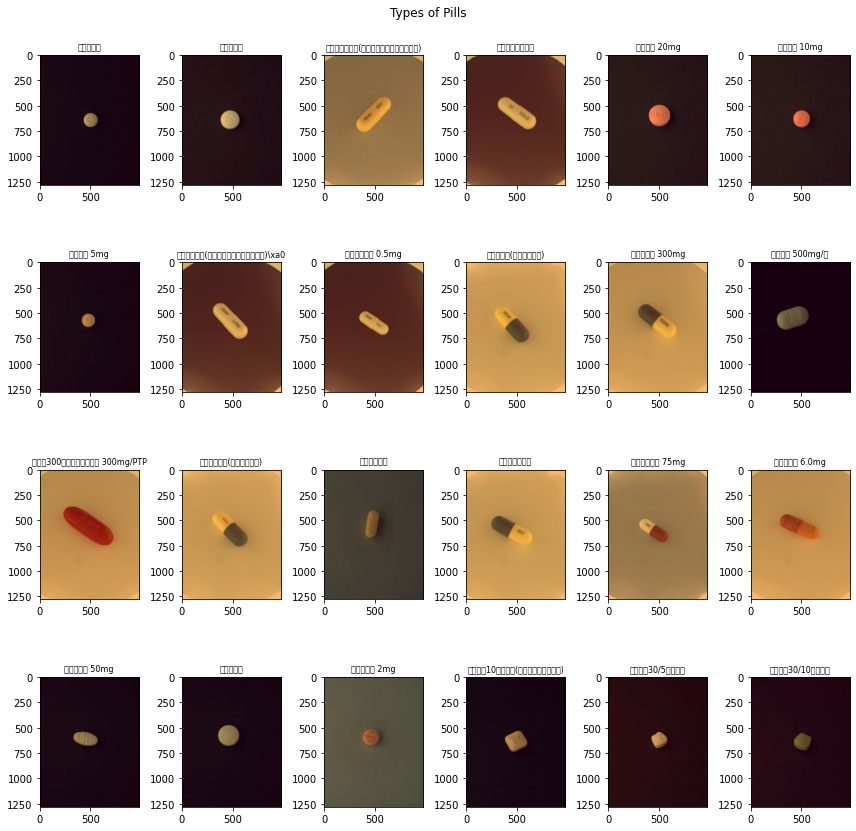

In [8]:

# 24 종의 약을 이미지화
def pills_img(pills_df):
    img_PATH = './pills/pills_data/data/Training/img/pills_5000/TS_81/'
    f, ax = plt.subplots(nrows=4,ncols=6, figsize=(12,12))

    idx = 0
    for i in range(4):
        for j in range(6):
        
            img = list(pills_df.iloc[:,0])[idx][2:-2]
            folder_1 = list(pills_df.iloc[:,0])[idx][2:10] #첫 폴더
            img_color = plt.imread(img_PATH + folder_1 + '/'+img)
            title = list(pills_df.iloc[:,1])[idx][2:-2]

            ax[i][j].imshow(img_color, resample=True)
            ax[i][j].set_title(title, fontsize=8)
            idx+=1
            
    plt.suptitle("Types of Pills")
    plt.tight_layout()
    plt.show()

pills_img(pills_df)

이미지를 통해 다음을 알 수 있다.

1. 모두 같은 크기의 이미지이다.
2. 용량에 따라 알약의 색과 크기도 변한다.
3. 크기만 다른 알약도 존재한다.

정말 크기만 다른지 알기 위해서  
크라틴정 삼총사를 들여다 보았다.

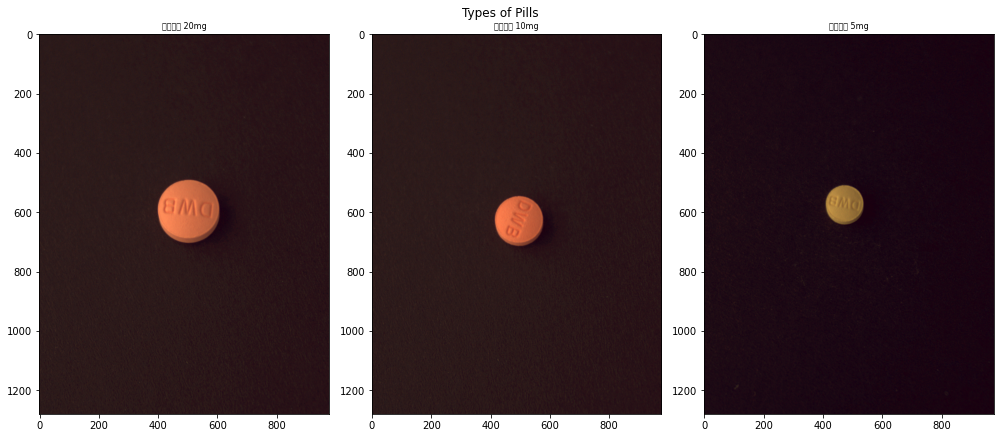

In [190]:
f, ax = plt.subplots(nrows=1,ncols=3, figsize=(14,6))

idx = 4
for i in range(3):
        
    img = list(pills_df.iloc[:,0])[idx][2:-2]
    folder_1 = list(pills_df.iloc[:,0])[idx][2:10] #첫 폴더
    img_color = plt.imread(img_PATH + folder_1 + '/'+img)
    title = list(pills_df.iloc[:,1])[idx][2:-2]

    ax[i].imshow(img_color, resample=True)
    ax[i].set_title(title, fontsize=8)
    idx+=1
            
plt.suptitle("Types of Pills")
plt.tight_layout()
plt.show()

아니 얘네는 너무 똑같잖아,, 싶었다.  
특히 10mg 과 20mg 은 정확하게 사이즈만 달랐다.  
허나 우리의 목표는 잘못된 약의 섭취를 막는 것이므로  

세 가지 용량의 크라틴정 중 하나만을 데이터 셋에 넣기로 했다.
이 뿐만 아니라 이미지가 상당히 유사한 약들을 제외하여  
총 20개의 약 종류를 남겼다.

뺀 네 가지의 종류는 다음과 같다

- 바실리포미스캡슐
- 크라틴정 10mg
- 크라틴정 5mg
- 루키오정10밀리그램(몬테루카스트나트륨)

In [30]:
print(f'총 {len(idx_nm_1) + len(idx_nm_2) + len(idx_nm_3) + len(idx_nm_4)} 개 제거')

총 2052 개 제거


In [28]:
idx_nm_1 = df[df['dl_name'] == "['크라틴정 10mg']"].index
idx_nm_2 = df[df['dl_name'] == "['크라틴정 5mg']"].index
idx_nm_3 = df[df['dl_name'] == "['루키오정10밀리그램(몬테루카스트나트륨)']"].index
idx_nm_4 = df[df['dl_name'] == "['바실리포미스캡슐']"].index

df_processed = df.drop(idx_nm_1)
df_processed = df_processed.drop(idx_nm_2)
df_processed = df_processed.drop(idx_nm_3)
df_processed = df_processed.drop(idx_nm_4)

df_processed

,file,dl_name
0,['K-038884_0_0_0_0_75_000_200.png'],['에피나레정']
1,['K-038884_0_0_0_0_75_020_200.png'],['에피나레정']
2,['K-038884_0_0_0_0_75_040_200.png'],['에피나레정']
3,['K-038884_0_0_0_0_75_060_200.png'],['에피나레정']
4,['K-038884_0_0_0_0_75_080_200.png'],['에피나레정']
...,...,...
9607,['K-039147_0_2_1_2_90_260_200.png'],['듀카브정30/10밀리그램']
9608,['K-039147_0_2_1_2_90_280_200.png'],['듀카브정30/10밀리그램']
9609,['K-039147_0_2_1_2_90_300_200.png'],['듀카브정30/10밀리그램']
9610,['K-039147_0_2_1_2_90_320_200.png'],['듀카브정30/10밀리그램']


## 2-2. 데이터 전처리

In [37]:
from sklearn.model_selection import train_test_split
from sklearn import metrics


# 데이터 균형 함수
def split_data(df):

    train, test = train_test_split(df, random_state=24)
    train, val = train_test_split(train, test_size=0.1, random_state=24)
    ncat_bal = int(len(train)/train['dl_name'].astype('category').cat.categories.size)
    train_bal = train.groupby('dl_name', as_index=False).apply(lambda g:  g.sample(ncat_bal, replace=True)).reset_index(drop=True)

    return train_bal, test, val

train, test, val = split_data(df_processed)


# train_y  = pd.get_dummies(df['dl_name'], drop_first=False) # 0 1 0 0 처럼 각 종류에 원핫 인코딩
# train_y


In [32]:
print(f'{len(train)} 개의 학습데이터, {len(val)}개의 검증 데이터, {len(test)}개의 평가 데이터')

5103 개의 학습데이터, 567개의 검증 데이터, 1890개의 평가 데이터


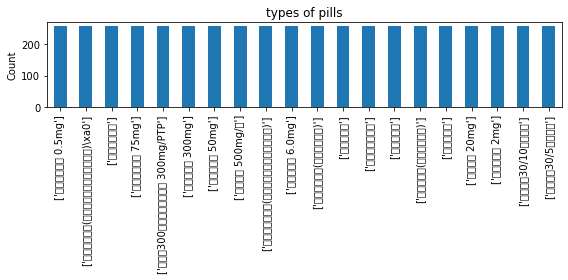

In [38]:
# 그래프를 그리는 함수
def plot(train_bees):
    """
    균형이 맞춰지기 전후 데이터를 그려 비교한다.

    Args:
        train_bees      : 균형을 맞추기 전 데이터
        train_bees_bal  : 균형이 맞춰진 데이터
        field_name      : 그리고 싶은 필드 이름
    """

    # Plot before and after balancing
    f, axs = plt.subplots(1,1, figsize=(8,4))

    # Before
    ax = train['dl_name'].value_counts().plot(kind='bar')
    ax.set_title('types of pills')
    ax.set_ylabel('Count')



    plt.tight_layout()
    plt.show()

plot(train)

## 2-3. 모델 학습

In [39]:
import imageio
import skimage
import skimage.io
import skimage.transform
import numpy as np

img_width=100
img_height=100
img_channels=3

def read_img(path):
    """
    크기와 채널을 조정해준다. 
    Caution: This function is not independent, it uses global vars: img_folder, img_channels
    """
    img_PATH = './pills/pills_data/data/Training/img/pills_5000/TS_81/'
    img = path[2:-2]
    folder_1 = path[2:10] #첫 폴더

    img = skimage.io.imread(img_PATH + folder_1 + '/'+img)
    img = skimage.transform.resize(img, (100, 100), mode='reflect')
    return img[:,:,:img_channels]


def prepare_train(train, val, test, field_name):
    """
    이미지 사진을 가져온다
    라벨을 원핫인코딩 한다.
    @return: image generator, train images, validation images, test images, train labels, validation labels, test labels
    """

    # Train data
    train_X = np.stack(train['file'].apply(read_img)) #새로운 축 추가해서 행렬 합침
    train_y  = pd.get_dummies(train[field_name], drop_first=False) # 0 1 0 0 처럼 각 종류에 원핫 인코딩

    # Validation during training data to calc val_loss metric
    val_X = np.stack(val['file'].apply(read_img))
    val_y = pd.get_dummies(val[field_name], drop_first=False)

    # Test data
    test_X = np.stack(test['file'].apply(read_img))
    test_y = pd.get_dummies(test[field_name], drop_first=False)


    # Data augmentation - 조금씩 회전, 확대, 이동 하여 데이터를 추가하였다.
    generator = ImageDataGenerator(
            featurewise_center=False,           # set input mean to 0 over the dataset
            samplewise_center=False,            # set each sample mean to 0
            featurewise_std_normalization=False,# divide inputs by std of the dataset
            samplewise_std_normalization=False, # divide each input by its std
            zca_whitening=False,                # apply ZCA whitening
            rotation_range=180,                 # randomly rotate images in the range (degrees, 0 to 180)
            zoom_range = 0.1,                   # Randomly zoom image 
            width_shift_range=0.2,              # randomly shift images horizontally (fraction of total width)
            height_shift_range=0.2,             # randomly shift images vertically (fraction of total height)
            horizontal_flip=True,               # randomly flip images
            vertical_flip=True)

    generator.fit(train_X)
    return (generator, train_X, val_X, test_X, train_y, val_y, test_y)

generator, train_X, val_X, test_X, train_y, val_y, test_y = prepare_train(train, val, test, 'dl_name')

In [40]:
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout, BatchNormalization,LeakyReLU
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
from keras.utils import to_categorical
import tensorflow

# We'll stop training if no improvement after some epochs
earlystopper1 = EarlyStopping(monitor='loss', patience=10, verbose=1)

# Save the best model during the traning
checkpointer1 = ModelCheckpoint('best_model1.h5'
                                ,monitor='val_acc'
                                ,verbose=1
                                ,save_best_only=True
                                ,save_weights_only=True)
# Build CNN model
model=Sequential()
model.add(Conv2D(6, kernel_size=3, input_shape=(img_width, img_height,3), activation='relu', padding='same'))
model.add(MaxPool2D(2))
model.add(Conv2D(12, kernel_size=3, activation='relu', padding='same'))
model.add(Flatten())
model.add(Dense(train_y.columns.size, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train
training = model.fit_generator(generator.flow(train_X,train_y, batch_size=60)
                        ,epochs=20
                        ,validation_data=(val_X, val_y) #[val_X, val_Y] 를 하면 안댐
                        ,steps_per_epoch=50
                        ,callbacks=[earlystopper1, checkpointer1])

# Get the best saved weights
#model1.load_weights('../best_model1.h5')

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
50/50 [==============================] - 12s 232ms/step - loss: 2.6084 - accuracy: 0.1487 - val_loss: 2.1165 - val_accuracy: 0.2857
Epoch 2/20
50/50 [==============================] - 9s 189ms/step - loss: 1.8570 - accuracy: 0.3137 - val_loss: 1.7621 - val_accuracy: 0.3704
Epoch 3/20
50/50 [==============================] - 9s 185ms/step - loss: 1.5122 - accuracy: 0.4470 - val_loss: 1.4839 - val_accuracy: 0.3721
Epoch 4/20
50/50 [==============================] - 9s 183ms/step - loss: 1.3055 - accuracy: 0.5223 - val_loss: 1.1977 - val_accuracy: 0.4921
Epoch 5/20
50/50 [==============================] - 9s 183ms/step - loss: 1.1370 - accuracy: 0.5997 - val_loss: 1.1241 - val_accuracy: 0.6261
Epoch 6/20
50/50 [==============================] - 9s 183ms/step - loss: 0.9634 - accuracy: 0.6740 - val_loss: 1.0592 - val_accuracy: 0.6208
Epoch 7/20
50/50 [==============================] - 9s 185ms/step - los

## 2-4. 데이터 평가

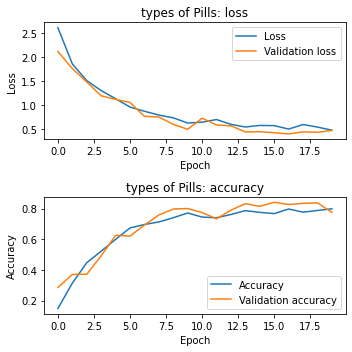

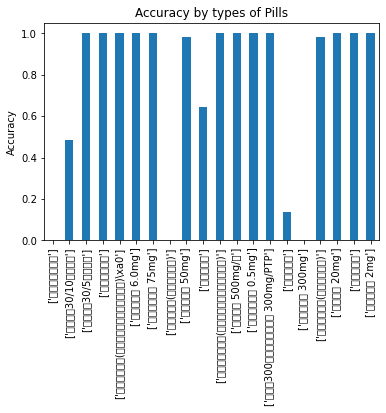

Classification report
                              precision    recall  f1-score   support

                 ['뉴에르도테캡슐']       0.00      0.00      0.00        80
           ['듀카브정30/10밀리그램']       1.00      0.52      0.69       305
            ['듀카브정30/5밀리그램']       0.71      1.00      0.83       320
                  ['라노펜세미정']       1.00      1.00      1.00        56
['락토엔큐캡슐(바실루스리케니포르미스균)\xa0']       1.00      1.00      1.00        90
             ['리셀톤캡슐 6.0mg']       1.00      1.00      1.00        71
             ['리프레가캡슐 75mg']       1.00      1.00      1.00        83
           ['뮤코원캡슐(에르도스테인)']       0.00      0.00      0.00        74
              ['베아로탄정 50mg']       0.53      1.00      0.70        55
                   ['베아투스정']       1.00      0.77      0.87        48
   ['비오메틱스캡슐(바실루스리케니포르미스균)']       1.00      1.00      1.00        66
            ['비우미정 500mg/병']       1.00      1.00      1.00        51
            ['아나그레캡슐 0.5mg']       1.00      1.00      1.00        

In [41]:
def eval_model(training, model, test_X, test_y, field_name):
    """
    예측값과 test 데이터를 바탕으로 정확도 예측
    시각화
    """
    ## Trained model analysis and evaluation
    f, ax = plt.subplots(2,1, figsize=(5,5))
    ax[0].plot(training.history['loss'], label="Loss")
    ax[0].plot(training.history['val_loss'], label="Validation loss")
    ax[0].set_title('%s: loss' % field_name)
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].legend()
    
    # Accuracy
    ax[1].plot(training.history['accuracy'], label="Accuracy")
    ax[1].plot(training.history['val_accuracy'], label="Validation accuracy")
    ax[1].set_title('%s: accuracy' % field_name)
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()
    plt.tight_layout()
    plt.show()

    # Accuracy by subspecies
    test_pred = model.predict(test_X)
    
    acc_by_subspecies = np.logical_and((test_pred > 0.5), test_y).sum()/test_y.sum()
    acc_by_subspecies.plot(kind='bar', title='Accuracy by %s' % field_name)
    plt.ylabel('Accuracy')
    plt.show()

    # Print metrics
    print("Classification report")
    test_pred = np.argmax(test_pred, axis=1)
    test_truth = np.argmax(test_y.values, axis=1)
    print(metrics.classification_report(test_truth, test_pred, target_names=test_y.columns))

    # Loss function and accuracy
    test_res = model.evaluate(test_X, test_y.values, verbose=0)
    print('Loss function: %s, accuracy:' % test_res[0], test_res[1])

eval_model(training, model, test_X, test_y, 'types of Pills')

정확도 77%가 나온 것을 알 수 있다.  
다만, 첫 번째, 여덟 번째, 열 여섯 번째 알약들에 대해서는  
전혀 예측하지 못하고 있는 모습을 보인다.  

예측이 안되는 약들이 어떤 약들인지를 시각화하였다.

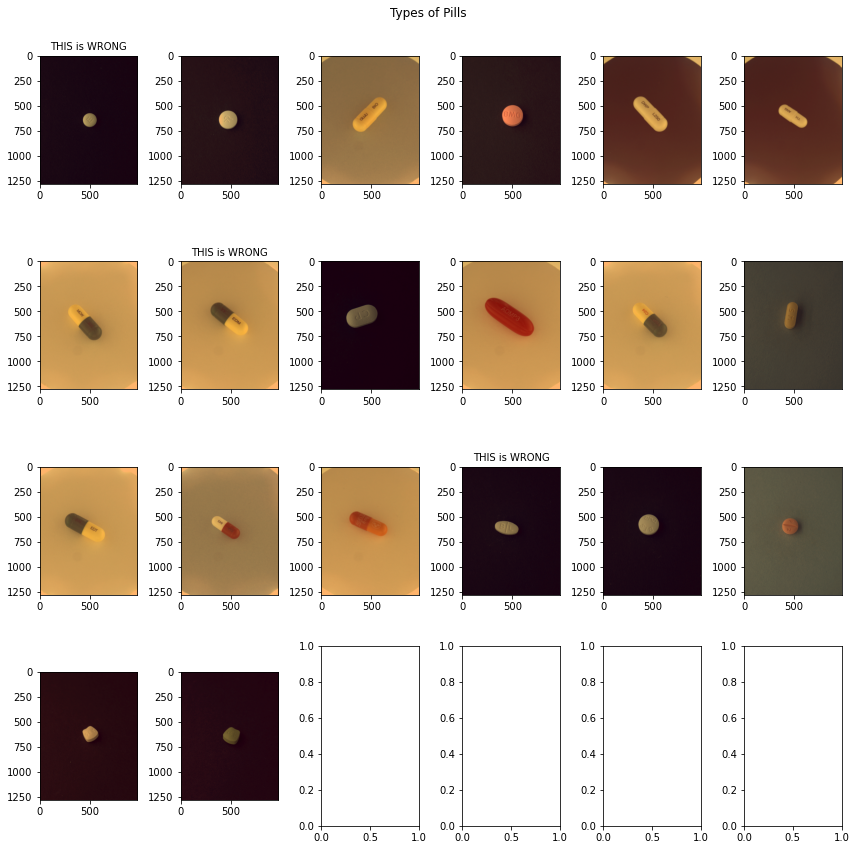

In [54]:

# 24 종의 약을 이미지화
pills_df_processd = make_pills_one(df_processed)

def pills_img(pills_df):
    img_PATH = './pills/pills_data/data/Training/img/pills_5000/TS_81/'
    f, ax = plt.subplots(nrows=4,ncols=6, figsize=(12,12))

    idx = 0
    for i in range(4):
        for j in range(6):
        
            img = list(pills_df.iloc[:,0])[idx][2:-2]
            folder_1 = list(pills_df.iloc[:,0])[idx][2:10] #첫 폴더
            img_color = plt.imread(img_PATH + folder_1 + '/'+img)
            title = list(pills_df.iloc[:,1])[idx][2:-2]

            ax[i][j].imshow(img_color, resample=True)
            ax[i][j].set_title("", fontsize=10)

            if idx == 0:
                ax[i][j].set_title("THIS is WRONG", fontsize=10)
            
            if idx == 7:
                ax[i][j].set_title("THIS is WRONG", fontsize=10)

            if idx == 15:
                ax[i][j].set_title("THIS is WRONG", fontsize=10)

            idx+=1

            if idx==20:
                break

        if idx == 20:
            break
    plt.suptitle("Types of Pills")
    plt.tight_layout()
    plt.show()


pills_img(pills_df_processd)


나로서는 다른 약들과의 차이가 무엇인지 판별하기가 어려웠다.

# 3. POTG
## 3-1. 소감

### 😵‍💫 경로 설정이 어려웠어요

각 약들에 대한 종류와 설명이 디렉토리에 따라 상당히 세분화 되어있었다.  
따라서 각 디렉토리 경로를 설정해주고 훈련시 한번에 사용할 수 있도록 구성해주는 작업이  
이번 프로젝트의 메인이었다.

이번 프로젝트에서는 각 폴더의 json 파일 중 파일경로와 이름을 뺴와서  
데이터 프레임으로 합쳐준 뒤

텐서플로우의 `train_test_split` 메서드를 사용해 분리해 사용하였다.